In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from itertools import groupby
%matplotlib inline

In [2]:
pd.options.display.max_rows = 300
pd.options.display.max_columns = 100

In [466]:
class API:
    def __init__(self):
        self.base = 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&'
    
    def datasetList(self):
        url = self.base+'&method=GETDATASETLIST'
        req = requests.get(url)
        ret = req.json()        
        return ret
        
    def paramList(self,datasetname):
        url = self.base+'&method=GETPARAMETERLIST&datasetname='+datasetname
        req = requests.get(url)
        ret = req.json()
        return(ret)
    
    def paramValues(self, datasetname, parametername):
        url = self.base+'&method=GETPARAMETERVALUES&datasetname='+datasetname+'&parametername='+parametername
        req = requests.get(url)
        ret = req.json()
        return(ret)
    
    def parseNames(self, data):
        nameList = []
        for x in data['BEAAPI']['Results'].keys():
            for y in data['BEAAPI']['Results'][x]:
                nameList.append(y)
        return nameList[:-1]
    
    def parseMethods(self, data):
        methodList = []
        for x in range(len(data['BEAAPI']['Results']['Parameter'])):
            try:
                methodList.append(data['BEAAPI']['Results']['Parameter'][x]['ParameterName'])
            except KeyError:
                pass
        return methodList
    
    def parseValues(self, data, which):
        valueList = []
        for x in range(len(data['BEAAPI']['Results']['ParamValue'])):
            try: 
                val = list(data['BEAAPI']['Results']['ParamValue'][x].values())
                valueList.append(val[which])
            except KeyError:
                pass
        return valueList
    
    def createDatalist(self):
        datasets = self.parseNames(a1.datasetList())
        
        params = {} #dictionary of dataset names as keys with corresponding value as a list of methods for that dataset
        paramVals = {} #dictionary of dataset name and parameter as keys with corresponding value as a list of possible values for that parameter
        #paramDesc = {} #Corresponding keyvalue as a description of possible values for that parameter
        for x in range(len(datasets)):
            params[datasets[x]['DatasetName']] = self.parseMethods(self.paramList(datasets[x]['DatasetName']))
            paramVals[datasets[x]['DatasetName']] = {}
            #paramDesc[datasets[x]['DatasetName']] = {}
            for y in params[datasets[x]['DatasetName']]:
                paramVals[datasets[x]['DatasetName']][y] = self.parseValues(self.paramValues(datasets[x]['DatasetName'], y), 0)
                #paramDesc[datasets[x]['DatasetName']][y] = self.parseValues(self.paramValues(datasets[x]['DatasetName'], y), 1)
        print(params)
        print(paramVals)
        return paramVals #, paramDesc
    
    def getDataSettings(self, paramlistdata):
        paramSettings = {}
        for x in paramlistdata['BEAAPI']['Results']['Parameter']:
            paramSettings[x['ParameterName']] = {}
            paramSettings[x['ParameterName']]['MultipleAccepted'] = x['MultipleAcceptedFlag'] 
            #paramSettings[x['ParameterName']]['ParamRequired'] = x['ParameterIsRequiredFlag'] don't care about this right now
            try:
                if x['AllValue']:
                    paramSettings[x['ParameterName']]['AllVal'] = x['AllValue'] 
            except KeyError:
                pass
        return paramSettings
    
    def createURLS(self, paramVals, paramSettings, dsetName):
        urlComponents = {}
        multA = []
        only1 = []
        allVal = {}
        for x in paramSettings: #for parameter in NIPA
            if paramSettings[x]['MultipleAccepted'] == str(1): #paramSettings[Frequency][MultipleAccepted] == yes
                multA.append(x) #Frequency 
            else:
                only1.append(x) #TableID
            try:
                if paramSettings[x]['AllVal']: #paramSettings[Year]['AllVal'] == 'X'
                    allVal[x] = paramSettings[x]['AllVal'] #Year = 'X'
            except KeyError:
                pass
            
        baseUrl = self.base+'&method=GETDATA'+'&datasetname='+dsetName+'&'
        url= baseUrl
        URLs = {}
        for y in multA:
            url += y+'='
            if y in allVal:
                url += allVal[y] + ','
            else:
                for t in paramVals[y]:
                    url += t + ','
            url = url.rstrip(',')
            url+= '&'
        for j in only1:
            url += j+'='
            URLs[dsetName] = {}
            urlB = url
            for k in paramVals[j]:
                url = urlB
                url += k + ','
                url = url.rstrip(',')
                url += '&'
                URLs[dsetName][k] = url.rstrip('&')
        return URLs

a1 = API()
vals = a1.createDatalist()
urls = []
for x in a1.parseNames(a1.datasetList()):
    urls.append(a1.createURLS(vals[x['DatasetName']], a1.getDataSettings(a1.paramList(x['DatasetName'])), x['DatasetName']))
print(urls)
#to fix:
#NIPA ok, NIUnderlyingDetail ok, MNE= create exception for all values (Perhaps with a request evaluation), FixedAssets = ok, Regional no, Others missing. 

KeyboardInterrupt: 

In [3]:
class getParams:
    def __init__(self):
        self.base = 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&'
    
    def datasetList(self):
        url = self.base+'&method=GETDATASETLIST'
        req = requests.get(url)
        ret = req.json()        
        retname = [i['DatasetName'] for i in ret['BEAAPI']['Results']['Dataset']]
        return retname[:-1]
        
    def paramList(self, name):
        url = self.base+'&method=GETPARAMETERLIST&datasetname='+name
        req = requests.get(url)
        ret = req.json()['BEAAPI']['Results']['Parameter']
        return ret
    
class getValues(getParams):
    
    def __init__(self, dName):
        self.dName = dName
        self.values = getParams.paramList(getParams(),dName)
    
    def reqValues(self):
        param_names = [[i[0] for i in self.values[self.dName]]]
        
        param_and_value = {}
        for listname in param_names:
            for name in listname:
                url = getParams().base+'&method=GETPARAMETERVALUES&datasetname='+self.dName+'&parametername='+name
                req = requests.get(url)
                ret = req.json() 
                param_and_value[name] = [i for i in ret['BEAAPI']['Results']['ParamValue']]
        print(param_and_value)
                
        param_mods = [i[1] for i in self.values[self.dName]]
        return param_and_value
    
#class getNIPA(getParams):
    
#class getFixedAssets(getParams):
    
    

class getMNE(getValues,getParams):
    
    def __init__(self,dname='MNE'):
        self.dname = dname
        param_vals = getParams.paramList(getParams(), dname)
        params = getValues.reqValues(getValues())
        super().__init__(self.dname)
    
    def createUrl(self, dirInv, classval):
        
        if dirInv == 'Inward' or 'Outward':
            urlComponents = {'DirectionOfInvestment': dirInv, 'Classification': classval,
                                               'Year': 'all', 'GetFootnotes': 'yes'}
        
        url = getParams().base+list(urlComponents.keys())[0]+'='+urlComponents['DirectionOfInvestment']+'&'+list(urlComponents.keys())[1]+'='+urlComponents['Classification']
        print(url)
        #state = {'USTot': '90', 'OtherUSAreas': '70', 'Foreign': '75', 'AllStatesAllAreas': 'all'}
        #state = state[stateselector]
        #possibleresults = 4 #
        
    
        #urlComponents = {'ParameterName' : {'DirectionOfInvestment': dirInv, 'OwnerShipLevel': ownLevel,
         #                                  'NonbankAffiliatesOnly' : nbaf, 'Classification': classval,
          #                                 'Country': country, 'Industry' : industry, 
           #                                 'Year': 'all', 'State': state, 
            #                               'SeriesID'}}

In [4]:
class GetParameters:
    def __init__(self):
        self.base = 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&'

    def paramList(self, name):
        url = self.base+'&method=GETPARAMETERLIST&datasetname='+name
        req = requests.get(url)
        ret = req.json()['BEAAPI']['Results']['Parameter']
        return ret
    
class GetData(GetParameters):
    def __init__(self,dname):
        super().__init__()
        self.vals = super().paramList(dname)
        self.parname = [i['ParameterName'] for i in self.vals]
        self.dname = dname
    
    def paramVals(self):
        
        paramVal = {}
        for name in self.parname:
            url = self.base+'&method=GETPARAMETERVALUES&datasetname='+self.dname+'&parametername='+name
            req = requests.get(url)
            ret = req.json() 
            paramVal[name] = [i for i in ret['BEAAPI']['Results']['ParamValue']]
        return paramVal
        
    def cases(self):
        
        if self.dname == 'MNE':
            urlmne = self.base+'&method=GETDATA'+'&datasetname='+self.dname+'&'
            dirInv = {'OutwardCountry': {'DirectionOfInvestment':'Outward', 'Classification': 'Country', 'Year':'All'},
                       'InwardCountry': {'DirectionOfInvestment':'Inward', 'Classification': 'Country', 'Year':'All'},
                       'OutwardIndustry': {'DirectionOfInvestment':'Outward', 'Classification': 'Industry', 'Year':'All'},
                       'InwardIndustry' : {'DirectionOfInvestment':'Inward', 'Classification': 'Industry', 'Year':'All'}}
        
            urls = {}
            for x in dirInv:
                urlcomp = ""
                for key,val in dirInv[x].items():
                    urlcomp += key+'='+val+'&'
                urlcomp = urlcomp.rstrip('&')
                urls[x] = urlmne+urlcomp
            print(urls)

            amneParams = {'Parent': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'},
                     'State': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'},
                     'Outward': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'},
                     'Inward': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'}}
        
        if self.dname == 'FixedAssets':
            tNamesFA = [i['TableName'] for i in self.paramVals()['TableName']]            
    
            urlFA = self.base+'method=GETDATA'+'&datasetname='+self.dname+'&tablename='
            urlsFA = {}

            for x in tNamesFA:
                urlsFA[x] = urlFA+x+'&year=All'
            print(urlsFA)
            

    

In [5]:
#datalist = getParams().datasetList()
#for x in datalist:
#    print(x)
#    a1 = getValues(x)
#    pnval = a1.reqValues()
a1 = GetData('MNE')
pnval = a1.cases()

#'Inward', 'Country'

{'OutwardCountry': 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&&method=GETDATA&datasetname=MNE&DirectionOfInvestment=Outward&Classification=Country&Year=All', 'InwardCountry': 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&&method=GETDATA&datasetname=MNE&DirectionOfInvestment=Inward&Classification=Country&Year=All', 'OutwardIndustry': 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&&method=GETDATA&datasetname=MNE&DirectionOfInvestment=Outward&Classification=Industry&Year=All', 'InwardIndustry': 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&&method=GETDATA&datasetname=MNE&DirectionOfInvestment=Inward&Classification=Industry&Year=All'}


In [6]:
url2test = 'https://apps.bea.gov/api/data/?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&&method=GETDATA&datasetname=MNE&DirectionOfInvestment=Outward&Classification=Country&Year=All'

In [7]:
class MNEProcessing:
    def __init__(self, url):
        self.address = url
    
    def dataRetrieval(self):
        req = requests.get(self.address)
        ret = req.json()['BEAAPI']['Results']['Data']
        return ret
    
    def parseData(self):
        data = self.dataRetrieval()
        data.sort(key=itemgetter('SeriesID','RowCode','Row','Year'))
        series25 = []
        for category, value in groupby(data, key=itemgetter('SeriesID','RowCode')):
            for i in value:
                series25.append(i)
        return series25
    
a1 = MNEProcessing(url2test)

In [8]:
a = a1.parseData()

In [826]:
print(a[:10])

[{'Year': '1999', 'SeriesID': '25', 'SeriesName': 'Reinvestment of Earnings Without Current-Cost Adjustment', 'Row': 'Addenda:', 'ColumnGParent': 'None', 'ColumnParent': 'None', 'Column': 'Reinvestment of Earnings', 'RowCode': ' ', 'ColumnCode': '0000', 'ColumnParentCode': '0', 'ColumnGParentCode': '0', 'TableScale': 'Millions of Dollars', 'DataValueUnformatted': 'n.a.', 'TableColumnDisplayOrder': '1.00', 'TableRowDisplayOrder': '80.00', 'DataValue': ''}, {'Year': '2000', 'SeriesID': '25', 'SeriesName': 'Reinvestment of Earnings Without Current-Cost Adjustment', 'Row': 'Addenda:', 'ColumnGParent': 'None', 'ColumnParent': 'None', 'Column': 'Reinvestment of Earnings', 'RowCode': ' ', 'ColumnCode': '0000', 'ColumnParentCode': '0', 'ColumnGParentCode': '0', 'TableScale': 'Millions of Dollars', 'DataValueUnformatted': 'n.a.', 'TableColumnDisplayOrder': '1.00', 'TableRowDisplayOrder': '80.00', 'DataValue': ''}, {'Year': '2001', 'SeriesID': '25', 'SeriesName': 'Reinvestment of Earnings Withou

In [12]:
data = pd.DataFrame(a)
data.drop(['ColumnGParent','ColumnParent','Column','RowCode','ColumnCode','ColumnParentCode'],axis=1, inplace=True)

In [13]:
allopec = data.groupby('Row').get_group('OPEC')
#us investments in opec since 1999

In [29]:
countrylist = sorted(data['Row'].unique()) #available countries
countrylist

['Addenda:',
 'Afghanistan',
 'Africa',
 'Albania',
 'Algeria',
 'All Countries Total',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Asia and Pacific',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Central America',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote D'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Eastern Europe',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Europ

In [31]:
allchina = data.groupby('Row').get_group('China')
allchina

,Year,SeriesID,SeriesName,Row,ColumnGParentCode,TableScale,DataValueUnformatted,TableColumnDisplayOrder,TableRowDisplayOrder,DataValue
1602,1999,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,442,1.00,66.00,442
1603,2000,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,768,1.00,66.00,768
1604,2001,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,560,1.00,66.00,560
1605,2002,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,1070,1.00,66.00,"1,070"
1606,2003,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,1271,1.00,66.00,"1,271"
1607,2004,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,2046,1.00,66.00,"2,046"
1608,2005,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,1839,1.00,66.00,"1,839"
1609,2006,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,3743,1.00,66.00,"3,743"
1610,2007,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,1997,1.00,66.00,"1,997"
1611,2008,25,Reinvestment of Earnings Without Current-Cost ...,China,0,Millions of Dollars,3509,1.00,66.00,"3,509"


In [30]:
alltotal = data.groupby('Row').get_group('All Countries Total')
alltotal

,Year,SeriesID,SeriesName,Row,ColumnGParentCode,TableScale,DataValueUnformatted,TableColumnDisplayOrder,TableRowDisplayOrder,DataValue
169,1999,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,48708,1.00,1.00,"48,708"
170,2000,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,77018,1.00,1.00,"77,018"
171,2001,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,52307,1.00,1.00,"52,307"
172,2002,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,65756,1.00,1.00,"65,756"
173,2003,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,100478,1.00,1.00,"100,478"
174,2004,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,141589,1.00,1.00,"141,589"
175,2005,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,-31182,1.00,1.00,"-31,182"
176,2006,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,196640,1.00,1.00,"196,640"
177,2007,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,210007,1.00,1.00,"210,007"
178,2008,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,212308,1.00,1.00,"212,308"


In [35]:
hk = data.groupby('Row').get_group('Hong Kong')
hk

,Year,SeriesID,SeriesName,Row,ColumnGParentCode,TableScale,DataValueUnformatted,TableColumnDisplayOrder,TableRowDisplayOrder,DataValue
1360,1999,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,1360,1.00,67.00,"1,360"
1361,2000,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,3509,1.00,67.00,"3,509"
1362,2001,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,3533,1.00,67.00,"3,533"
1363,2002,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,1330,1.00,67.00,"1,330"
1364,2003,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,2492,1.00,67.00,"2,492"
1365,2004,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,2879,1.00,67.00,"2,879"
1366,2005,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,-396,1.00,67.00,-396
1367,2006,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,4257,1.00,67.00,"4,257"
1368,2007,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,4768,1.00,67.00,"4,768"
1369,2008,25,Reinvestment of Earnings Without Current-Cost ...,Hong Kong,0,Millions of Dollars,4457,1.00,67.00,"4,457"


In [34]:
check2018 = data.groupby('SeriesID').get_group('25').groupby('Year').get_group('2018')

check2018

,Year,SeriesID,SeriesName,Row,ColumnGParentCode,TableScale,DataValueUnformatted,TableColumnDisplayOrder,TableRowDisplayOrder,DataValue
34,2018,25,Reinvestment of Earnings Without Current-Cost ...,Other-Africa,0,Millions of Dollars,532,1.00,58.00,532
56,2018,25,Reinvestment of Earnings Without Current-Cost ...,Other-Asia and Pacific,0,Millions of Dollars,543,1.00,78.00,543
78,2018,25,Reinvestment of Earnings Without Current-Cost ...,Other-Central America,0,Millions of Dollars,-100,1.00,43.00,-100
100,2018,25,Reinvestment of Earnings Without Current-Cost ...,Other-Europe,0,Millions of Dollars,549,1.00,26.00,549
122,2018,25,Reinvestment of Earnings Without Current-Cost ...,Other-Middle East,0,Millions of Dollars,-519,1.00,63.00,-519
144,2018,25,Reinvestment of Earnings Without Current-Cost ...,Other-Other Western Hemisphere,0,Millions of Dollars,(D),1.00,53.00,(D)
166,2018,25,Reinvestment of Earnings Without Current-Cost ...,Other-South America,0,Millions of Dollars,-1691,1.00,36.00,"-1,691"
188,2018,25,Reinvestment of Earnings Without Current-Cost ...,All Countries Total,0,Millions of Dollars,-323028,1.00,1.00,"-323,028"
210,2018,25,Reinvestment of Earnings Without Current-Cost ...,Canada,0,Millions of Dollars,17102,1.00,2.00,"17,102"
232,2018,25,Reinvestment of Earnings Without Current-Cost ...,Argentina,0,Millions of Dollars,647,1.00,29.00,647


In [24]:
print(allopec['SeriesName'].unique()) #available data

['Reinvestment of Earnings Without Current-Cost Adjustment'
 'Equity Outflows Other than Reinvestment of Earnings'
 'Debt Instruments Outflows'
 "Royalties and License Fees Net of Withholding Taxes, U.S. Parents' Receipts"
 "Other Private Services, U.S.  Parents' Receipts"
 "Royalties and License Fees Net of Withholding Taxes, U.S. Parents' Payments"
 "Other Private Services, U.S. Parents' Payments"]


In [21]:
opec25 = allopec.groupby('SeriesID').get_group('25')
opec32 = allopec.groupby('SeriesID').get_group('32')

In [22]:
opec32

,Year,SeriesID,SeriesName,Row,ColumnGParentCode,TableScale,DataValueUnformatted,TableColumnDisplayOrder,TableRowDisplayOrder,DataValue
17604,1999,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,85,1.00,83.00,85
17605,2000,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,2100,1.00,83.00,"2,100"
17606,2001,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,1230,1.00,83.00,"1,230"
17607,2002,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,2247,1.00,83.00,"2,247"
17608,2003,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,20,1.00,83.00,20
17609,2004,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,-2248,1.00,83.00,"-2,248"
17610,2005,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,1740,1.00,83.00,"1,740"
17611,2006,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,1589,1.00,83.00,"1,589"
17612,2007,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,9343,1.00,83.00,"9,343"
17613,2008,32,Equity Outflows Other than Reinvestment of Ear...,OPEC,0,Millions of Dollars,2206,1.00,83.00,"2,206"


In [19]:
print(allopec['SeriesID'].unique())

['25' '32' '33' '34' '35' '39' '40']


In [843]:
print(allopec['Row'].nunique())
print(allopec['ColumnCode'].nunique())

1
1


In [14]:
display(allopec)

,Year,SeriesID,SeriesName,Row,ColumnGParentCode,TableScale,DataValueUnformatted,TableColumnDisplayOrder,TableRowDisplayOrder,DataValue
1646,1999,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,-2269,1.00,83.00,"-2,269"
1647,2000,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,2864,1.00,83.00,"2,864"
1648,2001,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,2028,1.00,83.00,"2,028"
1649,2002,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,1198,1.00,83.00,"1,198"
1650,2003,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,1977,1.00,83.00,"1,977"
1651,2004,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,3667,1.00,83.00,"3,667"
1652,2005,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,4511,1.00,83.00,"4,511"
1653,2006,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,4742,1.00,83.00,"4,742"
1654,2007,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,2186,1.00,83.00,"2,186"
1655,2008,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,3783,1.00,83.00,"3,783"


In [15]:
display(allopec.loc[allopec.SeriesID == '25'])

,Year,SeriesID,SeriesName,Row,ColumnGParentCode,TableScale,DataValueUnformatted,TableColumnDisplayOrder,TableRowDisplayOrder,DataValue
1646,1999,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,-2269,1.00,83.00,"-2,269"
1647,2000,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,2864,1.00,83.00,"2,864"
1648,2001,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,2028,1.00,83.00,"2,028"
1649,2002,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,1198,1.00,83.00,"1,198"
1650,2003,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,1977,1.00,83.00,"1,977"
1651,2004,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,3667,1.00,83.00,"3,667"
1652,2005,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,4511,1.00,83.00,"4,511"
1653,2006,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,4742,1.00,83.00,"4,742"
1654,2007,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,2186,1.00,83.00,"2,186"
1655,2008,25,Reinvestment of Earnings Without Current-Cost ...,OPEC,0,Millions of Dollars,3783,1.00,83.00,"3,783"


In [715]:
vallist = []
yearlist = []
ctrylist = []
for x in a:
    vallist.append(x[0])
    yearlist.append(x[1])
    ctrylist.append(x[2])

In [760]:
print(ctrylist)

['All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total', 'All Countries Total']


<AxesSubplot:>

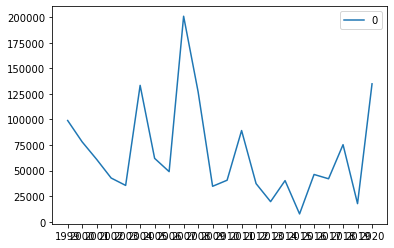

In [751]:
allctryDF = pd.DataFrame(vallist, index=yearlist)
allctryDF[0] = allctryDF[0].str.replace(',','').astype(int)
sns.lineplot(data=allctryDF)

In [759]:
display(allctryDF)

,0
1999,98929
2000,78041
2001,60942
2002,42707
2003,35484
2004,133277
2005,61937
2006,48970
2007,200850
2008,127037


In [703]:
from operator import itemgetter
from itertools import groupby

class DataProcessing:
    def __init__(self, url):
        self.address = url

    def dataRetrieval(self):
        req = requests.get(self.address)
        ret = req.json()
        return ret

    def parseData(self):
        data = self.dataRetrieval()
        seriescode = set()
        dvals = {}
        for x in range(len(data['BEAAPI']['Results']['Data'])):
            seriescode.add(str(data['BEAAPI']['Results']['Data'][x]['SeriesCode']))
        for code in seriescode:
            seriesList = []
            numList = []
            dvals[code] = {}
            for x in range(len(data['BEAAPI']['Results']['Data'])):
                if data['BEAAPI']['Results']['Data'][x]['SeriesCode'] == code:
                    seriesList.append((data['BEAAPI']['Results']['Data'][x]['DataValue'],data['BEAAPI']['Results']['Data'][x]['TimePeriod']))
                    dvals[code]['info'] = {'Description' : data['BEAAPI']['Results']['Data'][x]['LineDescription'], 
                                        'METRIC_NAME': data['BEAAPI']['Results']['Data'][x]['METRIC_NAME'], 
                                        'UNIT_MULT': data['BEAAPI']['Results']['Data'][x]['UNIT_MULT'],
                                        'CL UNIT' : data['BEAAPI']['Results']['Data'][x]['CL_UNIT']}
            davals[code]['data'] = seriesList
        return dvals
    
    def frameData(self):
        d = self.parseData()
        dframes = {}
        dframes = pd.DataFrame({k: dict(map(reversed, v['data'])) for k, v in d.items()}).T
        
        infoframe = {}
        for key in d.keys():
            infoframe[key] = d[key]['info']
        infoframe = pd.DataFrame(infoframe).T
        
        dframes = dframes.merge(infoframe, left_index=True, right_index=True)
        return dframes

In [318]:
value = {'BEAAPI': {'Request': {'RequestParam': [{'ParameterName': 'METHOD', 'ParameterValue': 'GETPARAMETERLIST'}, {'ParameterName': 'DATASETNAME', 'ParameterValue': 'FIXEDASSETS'}, {'ParameterName': 'USERID', 'ParameterValue': 'F2205008-0F90-4F72-B77E-D7938D6188E6'}, {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'}]}, 'Results': {'Parameter': [{'ParameterName': 'TableName', 'ParameterDataType': 'string', 'ParameterDescription': 'The new Fixed Assets identifier', 'ParameterIsRequiredFlag': '1', 'ParameterDefaultValue': '', 'MultipleAcceptedFlag': '0', 'AllValue': ''}, {'ParameterName': 'Year', 'ParameterDataType': 'integer', 'ParameterDescription': 'List of year(s) of data to retrieve (X for All)', 'ParameterIsRequiredFlag': '1', 'ParameterDefaultValue': '', 'MultipleAcceptedFlag': '1', 'AllValue': 'X'}]}}}

In [332]:
a = [i['AllValue'] for i in value['BEAAPI']['Results']['Parameter'] ]
a

['', 'X']

In [31]:
from operator import itemgetter
from itertools import groupby

class DataProcessing:
    def __init__(self, url):
        self.address = url

    def dataRetrieval(self):
        req = requests.get(self.address)
        ret = req.json()
        return ret

    def parseData(self):
        data = self.dataRetrieval()
        seriescode = set()
        dvals = {}
        for x in range(len(data['BEAAPI']['Results']['Data'])):
            seriescode.add(str(data['BEAAPI']['Results']['Data'][x]['SeriesCode']))
        for code in seriescode:
            seriesList = []
            numList = []
            dvals[code] = {}
            for x in range(len(data['BEAAPI']['Results']['Data'])):
                if data['BEAAPI']['Results']['Data'][x]['SeriesCode'] == code:
                    seriesList.append((data['BEAAPI']['Results']['Data'][x]['DataValue'],data['BEAAPI']['Results']['Data'][x]['TimePeriod']))
                    dvals[code]['info'] = {'Description' : data['BEAAPI']['Results']['Data'][x]['LineDescription'], 
                                        'METRIC_NAME': data['BEAAPI']['Results']['Data'][x]['METRIC_NAME'], 
                                        'UNIT_MULT': data['BEAAPI']['Results']['Data'][x]['UNIT_MULT'],
                                        'CL UNIT' : data['BEAAPI']['Results']['Data'][x]['CL_UNIT']}
            davals[code]['data'] = seriesList
        return dvals
    
    def frameData(self):
        d = self.parseData()
        dframes = {}
        dframes = pd.DataFrame({k: dict(map(reversed, v['data'])) for k, v in d.items()}).T
        
        infoframe = {}
        for key in d.keys():
            infoframe[key] = d[key]['info']
        infoframe = pd.DataFrame(infoframe).T
        
        dframes = dframes.merge(infoframe, left_index=True, right_index=True)
        return dframes

In [ ]:
tables = {}
for x in urls[0]['NIPA']:
    dset = DataProcessing(urls[0]['NIPA'][x])
    tables[x] = dset.frameData()

In [32]:
url = "https://apps.bea.gov/api/data/?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&method=GETDATA&datasetname=NIPA&Frequency=A,Q,M&Year=X&ShowMillions=N&TableID=T80400&TableName=T10101"
dset = DataProcessing(url)
table = dset.frameData()

In [114]:
urls = 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&method=GETPARAMETERLIST&datasetname=NIPA'
req = requests.get(urls)
ret = req.json()
ret

{'BEAAPI': {'Request': {'RequestParam': [{'ParameterName': 'USERID',
     'ParameterValue': 'F2205008-0F90-4F72-B77E-D7938D6188E6'},
    {'ParameterName': 'METHOD', 'ParameterValue': 'GETPARAMETERLIST'},
    {'ParameterName': 'DATASETNAME', 'ParameterValue': 'NIPA'},
    {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'}]},
  'Results': {'Parameter': [{'ParameterName': 'Frequency',
     'ParameterDataType': 'string',
     'ParameterDescription': 'A - Annual, Q-Quarterly, M-Monthly',
     'ParameterIsRequiredFlag': '1',
     'ParameterDefaultValue': '',
     'MultipleAcceptedFlag': '1',
     'AllValue': ''},
    {'ParameterName': 'ShowMillions',
     'ParameterDataType': 'string',
     'ParameterDescription': 'A flag indicating that million-dollar data should be returned.',
     'ParameterIsRequiredFlag': '0',
     'ParameterDefaultValue': 'N',
     'MultipleAcceptedFlag': '0',
     'AllValue': ''},
    {'ParameterName': 'TableID',
     'ParameterDataType': 'integer',
     'Par

In [136]:
a = [i['ParameterName'] for i in ret['BEAAPI']['Results']['Parameter']]

In [138]:
type(a)

list

In [220]:
value = {'MNE': {'Name': ['DirectionOfInvestment', 'OwnershipLevel', 'NonbankAffiliatesOnly', 'Classification ', 'Country', 'Industry', 'Year', 'State', 'SeriesID', 'GetFootnotes', 'Investment', 'ParentInvestment'], 'Multiple Accepted': ['0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '1', '1']}}

In [222]:
print(value)

{'MNE': {'Name': ['DirectionOfInvestment', 'OwnershipLevel', 'NonbankAffiliatesOnly', 'Classification ', 'Country', 'Industry', 'Year', 'State', 'SeriesID', 'GetFootnotes', 'Investment', 'ParentInvestment'], 'Multiple Accepted': ['0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '1', '1']}}


In [253]:
lis = list(zip([k for k in value['MNE']['Name']],[i for i in value['MNE']['Multiple Accepted']]))

In [249]:
for k in value['MNE']['Name']:
    print(k)

DirectionOfInvestment
OwnershipLevel
NonbankAffiliatesOnly
Classification 
Country
Industry
Year
State
SeriesID
GetFootnotes
Investment
ParentInvestment


In [254]:
lis

[('DirectionOfInvestment', '0'),
 ('OwnershipLevel', '0'),
 ('NonbankAffiliatesOnly', '0'),
 ('Classification ', '0'),
 ('Country', '1'),
 ('Industry', '1'),
 ('Year', '1'),
 ('State', '1'),
 ('SeriesID', '1'),
 ('GetFootnotes', '0'),
 ('Investment', '1'),
 ('ParentInvestment', '1')]

In [431]:
class Animal:
    def __init__(self, animalName):
        print(animalName, 'is an animal.');

# Mammal inherits Animal
class Mammal(Animal):
    def __init__(self, mammalName):
        print(mammalName, 'is a mammal.')
        super().__init__(mammalName)
    
# CannotFly inherits Mammal
class CannotFly(Mammal):
    def __init__(self, mammalThatCantFly):
        print(mammalThatCantFly, "cannot fly.")
        super().__init__(mammalThatCantFly)

# CannotSwim inherits Mammal
class CannotSwim(Mammal):
    def __init__(self, mammalThatCantSwim):
        print(mammalThatCantSwim, "cannot swim.")
        super().__init__(mammalThatCantSwim)

# Cat inherits CannotSwim and CannotFly
class Cat(CannotSwim, CannotFly):
    def __init__(self):
        print('I am a cat.');
        super().__init__('Cat')

# Driver code
cat = Cat()
print('')
bat = CannotSwim('Bat')

I am a cat.
Cat cannot swim.
Cat cannot fly.
Cat is a mammal.
Cat is an animal.

Bat cannot swim.
Bat is a mammal.
Bat is an animal.


In [463]:
test = {'A':'1', 'N':'2'}
test.keys()[0]

TypeError: 'dict_keys' object is not subscriptable

In [801]:
people = []
people.append({'born':1966, 'gender':'male', 'name':'Bob'})
people.append({'born':1966, 'gender':'female', 'name':'Anna'})
people.append({'born':1966, 'gender':'male', 'name':'Adam'})
people.append({'born':1970, 'gender':'male', 'name':'John'})
people.append({'born':1970, 'gender':'female', 'name':'Daisy'})
people.append({'born': 1968, 'gender':'male', 'name':'Steve'})


# First sort by required field
# Groupby only finds groups that are collected consecutively
people.sort(key=itemgetter('born'))

# Now iterate through groups (here we will group by the year born)
for born, items in groupby(people, key=itemgetter('born','name')):
    print (born)
    for i in items:
        print(' ', i)

(1966, 'Bob')
  {'born': 1966, 'gender': 'male', 'name': 'Bob'}
(1966, 'Anna')
  {'born': 1966, 'gender': 'female', 'name': 'Anna'}
(1966, 'Adam')
  {'born': 1966, 'gender': 'male', 'name': 'Adam'}
(1968, 'Steve')
  {'born': 1968, 'gender': 'male', 'name': 'Steve'}
(1970, 'John')
  {'born': 1970, 'gender': 'male', 'name': 'John'}
(1970, 'Daisy')
  {'born': 1970, 'gender': 'female', 'name': 'Daisy'}
